# Plot test dataset

In [124]:
import numpy as np
from astropy.io import fits
from astropy import cosmology, units, constants
import astropy.cosmology.units as cunits
import warnings
import os

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc, colors

In [ ]:
from ps_eor import datacube, pspec

In [4]:
rc("font", **{"family": "serif", "serif": ["times new roman"], "size": 15})
rc("text", usetex=True)
rc("axes", linewidth=1.5)

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
datafolder = './'

## Useful fonctions

In [60]:
def plot_ps2d(
        pspec_2d, kperp_bins, kpara_bins, dimless=False,
        label=r'P($k_\parallel$,$k_\perp$) [(Jy/beam)$^2$ Mpc$^3$]',
        norm=None, title=None, cmap='viridis', ax=None,
    ):
    """
    Method to plot cylindrical power spectrum with logarithmic colorbar.

    Parameters
    ----------
        pspec_2d: 2D array of floats
            Array containing the cylindrical power spectrum.
            Shape: (nkperp, nkpara).
        kperp_bins: array of floats
            Array containing the k_perpendicular bins used
            to compute the cylindrical power spectrum.
            Size: nkperp.
        kpara_bins: array of floats
            Array containing the k_parallel bins used
            to compute the cylindrical power spectrum.
            Size: nkpara.  
        dimless: boolean
            Whether the power spectrum is dimensionless or not.
            Default: False.
        label: str
            Label for the colorbar.
            Default is P(k) in (Jy/beam)2 Mpc3.
        norm: matplotlib.colors.Normalize object.
        title: str
            Title for the axis.
            Default is None.
        cmap: str
            Matplotlib colormap to use.
            Default is viridis.
        ax: matplotlib.axes object
            Axis to plot the figure on.
            Default is None (new figure and axis are generated).


    """

    kperp_bins = np.atleast_1d(kperp_bins)
    kpara_bins = np.atleast_1d(kpara_bins)
    assert np.shape(pspec_2d) == (kperp_bins.size, kpara_bins.size), \
        "Input pspec must have shape (kperp_bins.size, kpara_bins.size)."
    if np.any(pspec_2d < 0):
        warnings.warn(
            'There are negative values in your pspec. '
            'Absolute value will be used for the figure.'
        )
        pspec_2d = np.abs(pspec_2d)

    existing_axis = True
    if ax is None:
        fig, ax = plt.subplots(1, 1,)
        existing_axis = False
    if dimless:
        k = np.sqrt(kperp_bins[None, :]**2 + kpara_bins[:, None]**2)
        pspec2d *= k**3 *1./2./np.pi**2
        label = r'$\Delta^2(k)$ [K$^2$]'

    im = ax.pcolor(
        kperp_bins,
        kpara_bins,
        pspec_2d,
        shading='auto',
        cmap=cmap,
        norm=norm,
    )
    if not existing_axis:
        plt.colorbar(im, label=label, ax=ax)
        ax.set_ylabel(r'k$_\parallel$ [Mpc$^{-1}]$')
        ax.set_xlabel(r'k$_\perp$ [Mpc$^{-1}]$')
    if title is not None:
        ax.set_title(title)


def plot_ps1d(pspec_1d, kbins, yerr=None, title=None, dimless=False, ax=None, plot_kwargs={}):
    """
    Method to plot spherical power spectrum.

    Parameters
    ----------
        pspec_1d: 1D array of floats
            Array containing the spherical power spectrum.
            Must have same shape as kbins.
        kbins: array of floats
            Array containing the spherical k-bins used
            Must have same shape as pspec_1d.
        yerr: array of floats (optional)
            Array containing the errors on pspec_1d.
            Must have same shape as pspec_1d.
            Default is None.
        title: str
            Title for the axis.
            Default is None.
        dimless: boolean
            Whether the power spectrum is dimensionless or not.
            Default: False.
        ax: matplotlib.axes object
            Axis to plot the figure on.
            Default is None (new figure and axis are generated).


    """

    assert kbins.size == pspec_1d.size, \
        "pspec_1d and kbins must have identical size."
    if yerr is not None:
        assert kbins.size == yerr.size, \
            "yerr and kbins must have identical size."

    m = pspec_1d > 0.
    if ax is None:
        fig, ax = plt.subplots()
    ls = plot_kwargs.get("ls", '-')
    color = plot_kwargs.get("color", 'C0')
    lw = plot_kwargs.get("lw", 1.5)
    label = plot_kwargs.get("label", None)

    if dimless:
        if yerr is not None:
            yerr = kbins[m]**3 * yerr[m] / 2./np.pi**2
        ax.errorbar(kbins[m], kbins[m]**3 * pspec_1d[m]/2./np.pi**2, yerr=yerr, color=color, marker='.', capsize=2, ls=ls, lw=lw, label=label)
        ylabel = r'$\Delta^2(k)$ [K$^2$]'
    else:
        if yerr is not None:
            yerr = yerr[m]
        ax.errorbar(kbins[m], pspec_1d[m], yerr=yerr, color=color, marker='.', capsize=2, label=label, ls=ls, lw=lw)
        ylabel = r'$P(k)$ [K$^2$ Mpc$^3$]'
    ax.set_yscale('log')
    ax.set_xscale('log')
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel(r'$k$ [Mpc$^{-1}]$')
    ax.set_ylabel(ylabel)

def plot_map(box, fov, ifreq=None, label=r'$T$ [K]', cmap='RdBu_r', title=None, norm=None, ax=None, uv=False):
    """
    Method to plot 2D sky map from lightcone.

    Parameters
    ----------
        box: 2D or 3D array of floats
            Array containing the lightcone.
            Dimensions (npix, npix, nfreqs).
        fov: float
            Field of view corresponding to the image.
            Must have units.
        ifreq: int
            Which frequency channel to plot if box is 3D.
            Default is None: nfreqs//2.
        label: str
            Label for the colorbar.
            Default is T [K].
        title: str
            Title for the axis.
            Default is None.
        cmap: str
            Matplotlib colormap to use.
            Default is RdBu_r.
        norm: matplotlib.colors.Normalize object.
        ax: matplotlib.axes object
            Axis to plot the figure on.
            Default is None (new figure and axis are generated).
        uv: boolean
            Whether you are plotting a (u, v) map or not.
            Default: False.


    """
    ang_res = fov / box.shape[0]
    if box.ndim == 3:
        if ifreq is None:
            ifreq = box.shape[-1]//2
        else:
            assert ifreq < box.shape[-1], \
                "ifreq must be smaller than box.shape[-1]."
        image = box[:, :, ifreq]
    elif box.ndim == 2:
        image = np.copy(box)
    else:
        raise ValueError('box must be of dimension 2 or 3.')

    if uv:
        xlin = np.linspace(
            1.22/fov.to(units.rad).value,
            1.22/ang_res.to(units.rad).value,
            box.shape[0]
        )
    else:
        xlin = np.linspace(
            -fov.to(units.deg).value/2,
            fov.to(units.deg).value/2,
            box.shape[0]
        )
    existing_axis = True
    if ax is None:
        fig, ax = plt.subplots(1, 1,)
        existing_axis = False

    im = ax.pcolor(
        xlin, xlin,
        image,
        shading='auto',
        norm=norm,
        cmap=cmap
    )
    plt.colorbar(im, label=label, ax=ax)
    if uv:
        ax.set_ylabel(rf'$u$')
        ax.set_xlabel(rf'$v$')
    else:
        ax.set_ylabel(rf'$\theta$ [{fov.unit}]')
        ax.set_xlabel(rf'$\theta$ [{fov.unit}]')
    if title is not None:
        ax.set_title(title)
    


In [82]:

def cyl_to_sph(cyl_ps, kperp_bins, kpara_bins, kbins=None, nbins=None):
    """
    Compute spherical power spectrum from cylindrical one.

    Parameters
    ----------
        ps_data: 2D array of floats
            2D cylindrical power spectrum.
        kperp_bins: array of floats
            kperp cylindrical bins used to obtain
            ps_data.
        kpara_bins: array of floats
            kpara cylindrical bins used to obtain
            ps_data.
        kbins: array or list of floats
            Spherical k-bins to use.
            Units should be Mpc-1.
            All values should be positive.
            Default is None.
        nbins: int
            Number of bins to use when building the spherical power
            spectrum. Set to kbins.size if kbins is fed.
            Default is 30.
    Returns
    -------
        kbins: array of floats
            Spherical k-bins used, weighted by cell population.
        pspec: array of floats
            Spherical power spectrum in units of mK2 Mpc^3.

    """
    # check dimensions
    assert np.shape(cyl_ps) == (kperp_bins.size, kpara_bins.size), \
        "Shapes of ps_data and of kperp and kpara bins do not match."

    k_mag = np.sqrt(kperp_bins[:, None]**2 + kpara_bins[None, :]**2)

    # define the spherical bins and bin edges
    if kbins is None:
        if nbins is None:
            nbins = 10
        else:
            nbins = int(nbins)
        kmin = np.min(k_mag) * 2.
        kmax = np.max(k_mag) / 2.
        bin_edges = np.histogram_bin_edges(
            np.sort(k_mag.flatten()),
            bins=nbins,
            range=(kmin, kmax)
        )
    else:
        dk = np.diff(kbins).mean()
        assert dk > 0
        bin_edges = np.arange(kbins.min()-dk/2, kbins.max()+dk, dk)
        assert np.size(bin_edges) == np.size(kbins) + 1
        nbins = kbins.size
    assert np.size(bin_edges) > 1, "Error obtaining kpar bins."

    pspec = np.zeros(len(bin_edges) - 1)
    weighted_k = np.zeros(len(bin_edges) - 1)
    for k in range(len(bin_edges) - 1):
        mask = (bin_edges[k] < k_mag) & (k_mag <= bin_edges[k + 1])
        if mask.any():
            pspec[k] = np.mean(cyl_ps[mask].real)  # [mk^2 Mpc^3]
            weighted_k[k] = np.mean(k_mag[mask])
    # Make sure there are no nans! If there are make them zeros.
    pspec[np.isnan(pspec)] = 0.0
    # Check empty bins
    if np.any(weighted_k == 0.):
        print('Some empty k-bins!')

    return weighted_k, pspec

## General parameters

In [ ]:
# 21cm rest-frame frequency
nu0 = 1420 * units.MHz

In [78]:
# BINS TO USE FOR HISTOGRAMMING

# k-range
kperp_bins = np.loadtxt(f'{datafolder}bins_kper.txt')
dkperp = np.diff(kperp_bins)[0]
kperp_edges = np.arange(kperp_bins.min()-dkperp/2, kperp_bins.max()+dkperp, dkperp)

kpara_bins = np.loadtxt(f'{datafolder}bins_kpar.txt')
dkpara= np.diff(kpara_bins)[0]
kpara_edges = np.arange(kpara_bins.min()-dkpara/2, kpara_bins.max()+dkpara, dkpara)


k_mag = np.sqrt(kperp_bins[:, None]**2 + kpara_bins[None, :]**2)
kmin = np.min(k_mag) / units.Mpc
kmax = np.max(k_mag) / units.Mpc
krange = np.linspace(kmin, kmax, 10).value

nbins = 10
kbins = np.linspace(np.min(k_mag), np.max(k_mag), nbins)
print(kbins)


[0.07071068 0.14142136 0.21213203 0.28284271 0.35355339 0.42426407
 0.49497475 0.56568542 0.6363961  0.70710678]


In [32]:
bmax = 5. * units.km
D_station = (35+40)/2 * units.m

In [35]:
total_time = 1000. * units.hour
int_time = 10.*units.second

## Load data cubes from FITS files

Choose spectral window to reduce computations:

In [30]:
df = 0.100 # MHz
fmin = 166.0
fmax = 180.9
spw_range = np.round(np.arange(fmin, fmax+df, step=df), decimals=2) * units.MHz
print(spw_range[-1])
avg_nu = np.mean(spw_range)
avg_z = nu0/avg_nu - 1.
lamb_array = constants.c.si / (spw_range.si)

180.9 MHz


Only keep part of file that has this limited spectral window

In [ ]:
def reduce_file(filename, spw_range):
    nf = spw_range.size
    hdu = fits.open(filename)
    nfreqs = hdu[0].header['NAXIS3']
    df = hdu[0].header['CDELT3'] * units.Hz
    fmin = hdu[0].header['CRVAL3'] * units.Hz
    fmax = fmin + df * nfreqs
    freqs = np.arange(fmin.value, fmax.value, step=df.value) * units.Hz
    assert fmin <= spw_range[0].to(units.Hz)
    assert fmax >= spw_range[-1].to(units.Hz)
    assert freqs.size == nfreqs
    inds = np.where((freqs<=spw_range[-1]) & (freqs>=spw_range[0]))[0]
    assert inds.size == nf
    hdu[0].data = hdu[0].data[inds, :, :]
    hdu[0].header['NAXIS3'] = nf
    hdu[0].header['CRVAL3'] = spw_range[0].to(units.Hz).value
    return hdu

In [ ]:
# REDUCING FILES
weighting = 'msn'

# PSF
reduced_psf_file = f'TestDataset.{weighting}_psf_reduced.fits'
if os.path.exists(reduced_psf_file):
    hdu = fits.open(reduced_psf_file)
    assert hdu[0].data.shape[0] == spw_range.size
    hdu.close()
else:
    psffolder = './' # location of the psf file downloaded from SKA SDC3 drive
    psffile = f'{psffolder}TestDataset.{weighting}_psf.fits'
    hdu = reduce_file(psffile, spw_range)
    du = abs(hdu[0].header['CDELT1'])
    npix = hdu[0].data.shape[1]
    hdu.writeto(reduced_psf_file, overwrite=True)
    hdu.close()

# IMAGE
reduced_image_file = f'IM1.{weighting}_image_reduced.fits'
if os.path.exists(reduced_image_file):
    hdu = fits.open(reduced_image_file)
    assert hdu[0].data.shape[0] == spw_range.size
    hdu.close()
else:
    imagefile = f'IM1.{weighting}_image.fits' # location of the image file downloaded from SKA SDC3 drive
    hdu = reduce_file(imagefile, spw_range)
    hdu.writeto(reduced_image_file, overwrite=True)
hdu.close()

150 150
150 150


In [71]:
fov = 1./du

Load PSF and image files and transform into a visibility cube:

In [36]:
w_cube = datacube.CartWeightCube.load_from_fits_image_and_psf(
    files=[f'IM1.{weighting}_image_reduced.fits'],
    files_psf=[f'TestDataset.{weighting}_psf_reduced.fits'],
    umin=max(50, D_station/np.mean(lamb_array)),  # 50 default
    umax=min(250, bmax.si/np.mean(lamb_array)),  # 250 default
    theta_fov=(1.22*np.mean(lamb_array)/D_station).value,
    int_time=int_time.to(units.s).value,
    total_time=total_time.to(units.s).value,
    use_wscnormf=False, # use pSF and not WSCNORMF to normalise the visibilities
    window_function=datacube.WindowFunction('hann') # or datacube.WindowFunction(('tukey', 0.2))
)

 Progress: 1 / 1 (Total: 0.00 s) 
 Progress: 1 / 1 (Total: 0.00 s) 
Filtering 0 modes (0.00 %)


In [37]:
w_cube.data.shape

(150, 600)

## Power spectra

In [39]:
cos = cosmology.FlatLambdaCDM(Om0=0.30964, H0=100.)

1. Read from file

Reference power spectrum, given by SDC3b team as the power spectrum  of IM1 above.

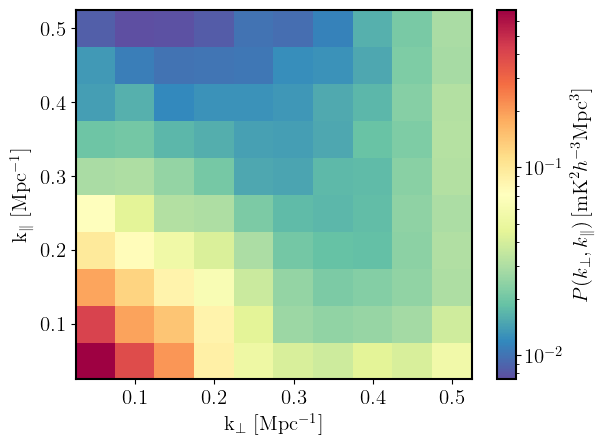

In [94]:
datafile = datafolder+f'Pk_PS3_{spw_range[0].to(units.MHz).value:.1f}_{spw_range[-1].to(units.MHz).value:.1f}.txt'
pspec_2d_from_file = np.loadtxt(datafile) * units.K**2 * units.Mpc**3 / cunits.littleh**3
# pspec_2d_from_file = pspec_2d_from_file.to(units.mK**2 * units.Mpc**3, cunits.with_H0(cos.H0)).value
plot_ps2d(
        pspec_2d_from_file, 
        kperp_bins, kpara_bins,
        cmap='Spectral_r', norm=colors.LogNorm(),
        label=r'$P(k_\perp, k_\parallel)\, [\mathrm{mK}^2 h^{-3} \mathrm{Mpc}^3]$'
)

In [96]:
w_kbins, pspec_1d_from_file = cyl_to_sph(pspec_2d_from_file.value, kperp_bins, kpara_bins, kbins=kbins)

2. Computed from the image

In [ ]:
eor_bin_list = pspec.EorBinList(w_cube.freqs)
# Create an EoR bin 122-134 MHz with a 120-136MHz range for the FG fitting
eor_bin_list.add_freq(1, 166, 181, 120, 136)
eor = eor_bin_list.get(1)


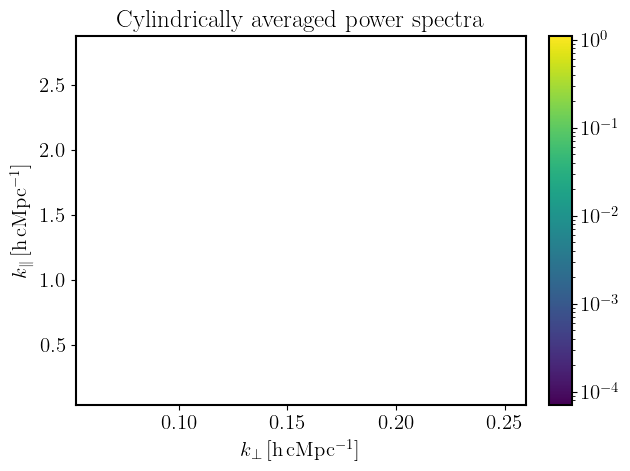

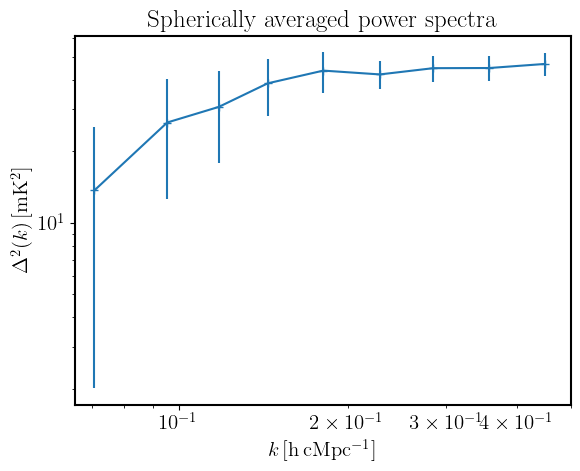

In [120]:
# Create a PS configuration
# el = 2 * np.pi * (np.arange(du, du*npix, du))
el = 2 * np.pi * (np.arange(w_cube.ru.min(), w_cube.ru.max(), 10.*du))
ps_conf = pspec.PowerSpectraConfig(el)

pb = datacube.SkaLowPrimaryBeam()

# Create a PS generation object
ps_gen = pspec.PowerSpectraCart(eor, ps_conf, pb)

# Create a Spatial PS, plot it and save it to a file
ps = ps_gen.get_ps(w_cube)
# ps.plot(title='Spatial power spectra')
# plt.savefig('ps.pdf')
# ps.save_to_txt('ps.txt')

# Create a Cylindrically averaged PS
ps2d = ps_gen.get_ps2d(w_cube)
ps2d.plot(title='Cylindrically averaged power spectra')#, vmin=pspec_2d_from_file.min().value, vmax=pspec_2d_from_file.max().value)
# plt.savefig('ps2d.pdf')
# ps2d.save_to_txt('ps2d.txt')

# Create a Spherically averaged PS
kbins2 = np.logspace(np.log10(ps_gen.kmin), np.log10(0.5), 10)
ps3d = ps_gen.get_ps3d(kbins2, w_cube)
ps3d.plot(title='Spherically averaged power spectra')
ax = plt.gca()
# ax.loglog(kbins, w_kbins**3 * pspec_1d_from_file / 2./ np.pi**2, color='k', label='From SDC3 team')

# plt.savefig('ps3d.pdf')
# ps3d.save_to_txt('ps3d.txt')


### Compare power spectra

Text(0.5, 0, '$k\\,[\\mathrm{h\\,cMpc^{-1}}]$')

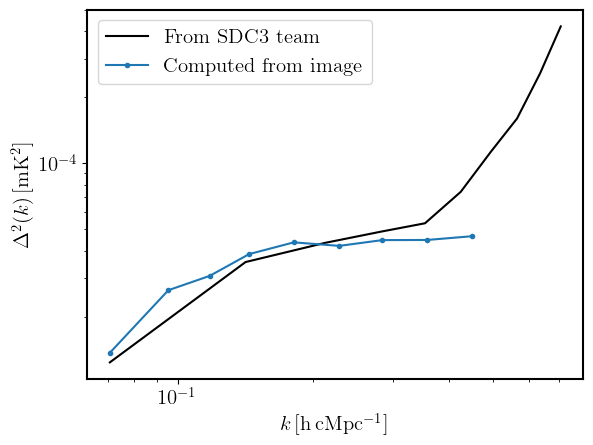

In [112]:
plt.figure()
plt.loglog(kbins, w_kbins**3 * pspec_1d_from_file / 2./ np.pi**2, color='k', label='From SDC3 team')
plt.loglog(ps3d.k_mean, ps3d.data, label='Computed from image', marker='.')
plt.legend()
plt.ylabel(r'$\Delta^2 (k)\,[\mathrm{mK}^2]$')
plt.xlabel(r'$k\,[\mathrm{h\,cMpc^{-1}}]$')